In [10]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import re
import tqdm
import os
from collections import defaultdict

In [2]:
plt.rcParams.update({
    'figure.figsize': (6, 4),            # Figure size
    'figure.dpi': 100,                   # High DPI for publication-quality images
    'axes.titlesize': 14,                # Title font size
    'axes.labelsize': 12,                # Axis label font size
    'axes.labelpad': 10,                 # Padding for labels
    'axes.linewidth': 1,                 # Axis line width
    'axes.grid': False,                  # Disable grid unless necessary
    'xtick.labelsize': 10,               # X-axis tick label size
    'ytick.labelsize': 10,               # Y-axis tick label size
    'xtick.major.size': 4,               # Length of major ticks
    'ytick.major.size': 4,               # Length of major ticks
    'xtick.major.width': 1,              # Width of major ticks
    'ytick.major.width': 1,              # Width of major ticks
    'xtick.direction': 'in',             # Ticks facing inwards
    'ytick.direction': 'in',             # Ticks facing inwards
    'legend.fontsize': 10,               # Legend font size
    'legend.frameon': False,             # Disable legend frame for a cleaner look
    'font.family': 'serif',              # Use a serif font for text
    'font.serif': ['DejaVu Serif'],      # Use 'DejaVu Serif' as the fallback serif font
    'lines.linewidth': 1.5,              # Line width for plots
    'lines.markersize': 6,               # Marker size
    'savefig.dpi': 300,                  # Save figure resolution
    'savefig.bbox': 'tight',             # Adjust layout to avoid clipping
})

In [3]:
# Load the stats data from the folder
model_keys = [
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/allenai_OLMoE-1B-7B-0924',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/allenai_OLMoE-1B-7B-0924-Instruct'
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/google_gemma-2-2b',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/google_gemma-2-2b-it',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/google_gemma-2b',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/keeeeenw_MicroLlama',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/meta-llama_Llama-3.1-8B',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/meta-llama_Llama-3.1-8B-Instruct',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/meta-llama_Llama-3.1-70B',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/microsoft_phi-2',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/microsoft_Phi-3.5-mini-instruct',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/mistralai_Mistral-7B-Instruct-v0.3',
    '/home/davidchan/Repos/random_needles/exps/contextual/die_roll/mistralai_Mistral-7B-v0.3',
]

model_stats_data = {}
for key in tqdm.tqdm(model_keys):
    if os.path.exists(f'{key}/stats.pkl'):
        with open(f'{key}/stats.pkl', 'rb') as f:
            model_stats_data[key.split('/')[-1]] = pickle.load(f)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 117.29it/s]


In [8]:
print(model_stats_data['allenai_OLMoE-1B-7B-0924']['biased_point'].keys())

dict_keys(['When I roll dice they land on 1 60% of the time.', 'When I roll dice they land on 1 80% of the time.', 'When I roll dice they land on 2 60% of the time.', 'When I roll dice they land on 2 80% of the time.', 'When I roll dice they land on 3 60% of the time.', 'When I roll dice they land on 3 80% of the time.', 'When I roll dice they land on 4 60% of the time.', 'When I roll dice they land on 4 80% of the time.', 'When I roll dice they land on 5 60% of the time.', 'When I roll dice they land on 5 80% of the time.', 'When I roll dice they land on 6 60% of the time.', 'When I roll dice they land on 6 80% of the time.'])


In [12]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

In [13]:
key_data = {}
for key, stats in model_stats_data.items():
    key_data[key] = defaultdict(list)
    if 'biased_point' not in stats:
        continue
    for k, v in stats['biased_point'].items():
        # Matches the bias percent
        percent = int(re.search(r"(\d+(\.\d+)?)%", k).group(1))
        # Matches the head (land on X Y% of the time) (matches X)
        head = int(re.search(r"land on (\d+)", k).group(1))

        key_data[key][head].append((percent, tvd(v['choice_probs'], np.exp(v["expected_dist"]))))
    for head in key_data[key]:
        key_data[key][head] = sorted(key_data[key][head], key=lambda x: x[0])

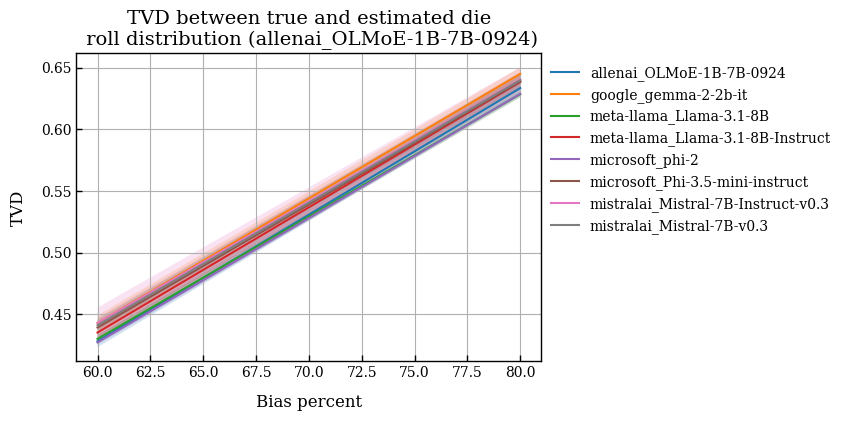

In [28]:
plt.clf()

# For each model, plot the mean and standard deviation of the TVD
for key, data in key_data.items():
    mean = np.mean([np.array(data[head])[:, 1] for head in data], axis=0)
    std = np.std([np.array(data[head])[:, 1] for head in data], axis=0)
    plt.plot(np.array(data[1])[:, 0], mean, label=key)
    plt.fill_between(np.array(data[1])[:, 0], mean - std, mean + std, alpha=0.2)

plt.xlabel('Bias percent')
plt.ylabel('TVD')
plt.legend(bbox_to_anchor=(1.65, 1))
plt.grid()
plt.title('TVD between true and estimated die\n roll distribution')
plt.show()